
# LSTM用データ前処理と可視化

このノートブックでは、ジェスチャー認識のためのLSTMモデル用にセンサーデータの前処理と可視化を行います。

## 処理内容
1. **データの読み込みと基本統計**: 生データの読み込み、データ形状・分布の確認
2. **センサーデータの可視化**: ジェスチャー分布、シーケンス長、センサー値の可視化
3. **スライディングウィンドウによる時系列データの分割**: 複数のウィンドウ設定で前処理
4. **正規化処理**: StandardScalerによる特徴量の標準化
5. **データの保存**: Optuna最適化用の形式で保存

## ウィンドウ設定
- **w64_s16**: ウィンドウサイズ64、ストライド16（高解像度）
- **w128_s32**: ウィンドウサイズ128、ストライド32（バランス型）

## 改良点
- **並列化**: マルチプロセシングによる高速化
- **欠損値フィルタリング**: 欠損値の多いウィンドウを自動除外
- **処理時間最適化**: w256_s64を削除して処理時間を短縮

In [1]:
# GPU環境確認（前処理でも確認）
try:
    import tensorflow as tf
    
    print("=== GPU環境確認 ===")
    print(f"TensorFlow バージョン: {tf.__version__}")
    
    # GPU利用可能性確認
    gpus = tf.config.list_physical_devices('GPU')
    print(f"利用可能なGPU: {len(gpus)}台")
    
    if gpus:
        print("GPU詳細:")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
        print("後続の学習でGPUが使用されます")
    else:
        print("GPU が見つかりません")
        print("学習はCPUで実行されます")
    
    print("=================")
    
except ImportError:
    print("TensorFlow がインストールされていません")
    print("学習を行う場合は以下をインストールしてください:")
    print("  pip install tensorflow[and-cuda]")


2025-07-06 17:32:34.290747: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-06 17:32:36.036886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751790756.825320   45429 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751790756.959187   45429 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751790758.198899   45429 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

=== GPU環境確認 ===
TensorFlow バージョン: 2.19.0
利用可能なGPU: 1台
GPU詳細:
  GPU 0: /physical_device:GPU:0
後続の学習でGPUが使用されます


In [2]:


# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
import os
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# 複数のウィンドウ設定（Optuna最適化用）
# w256_s64は処理時間が長すぎるため削除し、w64_s16とw128_s32のみ使用
WINDOW_CONFIGS = {
    'w64_s16': {'window_size': 64, 'stride': 16},
    'w128_s32': {'window_size': 128, 'stride': 32}
}

# 固定パラメータ
RANDOM_STATE = 42

print("ライブラリのインポート完了")
print(f"設定済みウィンドウ設定: {list(WINDOW_CONFIGS.keys())}")

ライブラリのインポート完了
設定済みウィンドウ設定: ['w64_s16', 'w128_s32']



# 1. データの読み込みと基本統計

In [3]:


# データの読み込み
print("データを読み込み中...")
train_df = pd.read_csv('../data/train.csv')
train_demographics = pd.read_csv('../data/train_demographics.csv')
test_df = pd.read_csv('../data/test.csv')

print(f"訓練データサイズ: {train_df.shape}")
print(f"テストデータサイズ: {test_df.shape}")
print(f"Demographics データサイズ: {train_demographics.shape}")

# 基本情報の表示
print("\n=== 訓練データの基本情報 ===")
print(train_df.info())

# 欠損値の確認
print("\n=== 欠損値の確認 ===")
missing_values = train_df.isnull().sum()
print(f"欠損値がある列数: {(missing_values > 0).sum()}")
if (missing_values > 0).sum() > 0:
    print("欠損値がある列:")
    print(missing_values[missing_values > 0])

データを読み込み中...
訓練データサイズ: (574945, 341)
テストデータサイズ: (107, 336)
Demographics データサイズ: (81, 8)

=== 訓練データの基本情報 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574945 entries, 0 to 574944
Columns: 341 entries, row_id to tof_5_v63
dtypes: float64(332), int64(1), object(8)
memory usage: 1.5+ GB
None

=== 欠損値の確認 ===
欠損値がある列数: 329
欠損値がある列:
rot_w         3692
rot_x         3692
rot_y         3692
rot_z         3692
thm_1         6987
             ...  
tof_5_v59    30142
tof_5_v60    30142
tof_5_v61    30142
tof_5_v62    30142
tof_5_v63    30142
Length: 329, dtype: int64


In [4]:


# センサー列の特定
sensor_cols = [col for col in train_df.columns if col.startswith(('acc_', 'rot_', 'tof_', 'thm_'))]
print(f"センサー列数: {len(sensor_cols)}")
print(f"センサー列: {sensor_cols[:10]}...")  # 最初の10個を表示

# ジェスチャーの分析
print("\n=== ジェスチャーの分布 ===")
gesture_counts = train_df['gesture'].value_counts()
print(gesture_counts)

# シーケンスの分析
print("\n=== シーケンスの分析 ===")
sequence_stats = train_df.groupby('sequence_id').agg({
    'sequence_counter': 'count',
    'gesture': 'first'
}).rename(columns={'sequence_counter': 'sequence_length'})

print(f"総シーケンス数: {len(sequence_stats)}")
print(f"シーケンス長の統計:")
print(sequence_stats['sequence_length'].describe())

センサー列数: 332
センサー列: ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3']...

=== ジェスチャーの分布 ===
gesture
Text on phone                                 58462
Neck - scratch                                56619
Eyebrow - pull hair                           44305
Forehead - scratch                            40923
Forehead - pull hairline                      40802
Above ear - pull hair                         40560
Neck - pinch skin                             40507
Eyelash - pull hair                           40218
Cheek - pinch skin                            40124
Wave hello                                    34356
Write name in air                             31267
Pull air toward your face                     30743
Feel around in tray and pull out an object    17114
Glasses on/off                                13542
Drink from bottle/cup                         13093
Scratch knee/leg skin                         12328
Write name on leg           



# 2. データの可視化

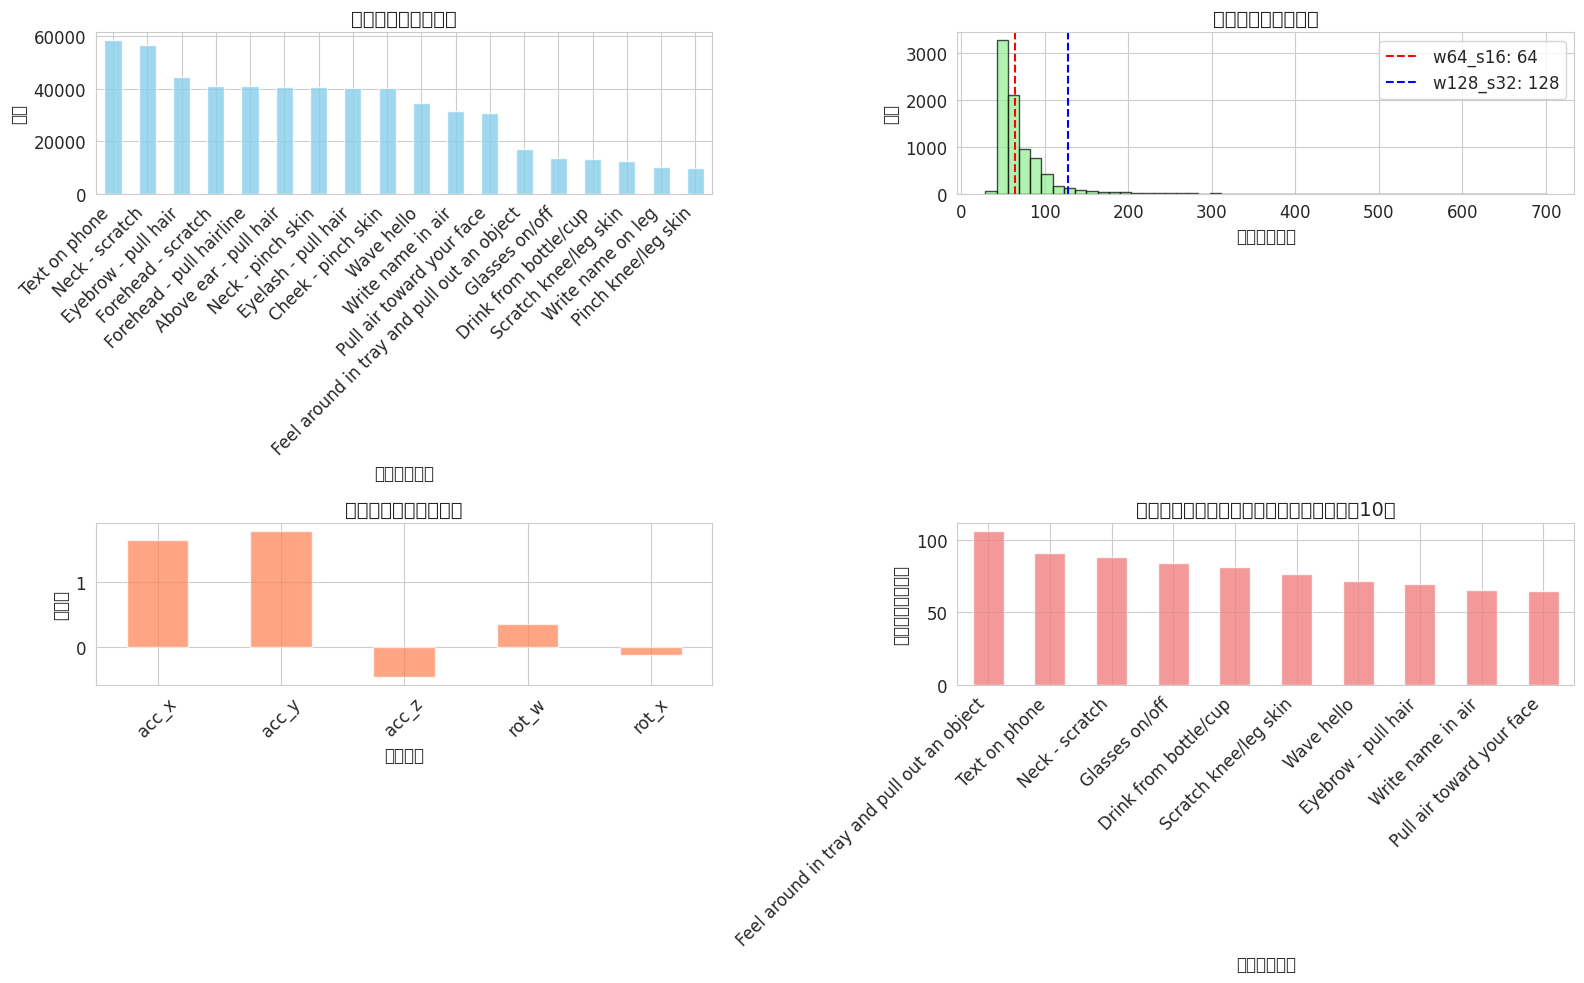

データ概要:
- 総レコード数: 574,945
- 総シーケンス数: 8,151
- ジェスチャー種類数: 18
- センサー特徴量数: 332
- 平均シーケンス長: 70.5
- 最小シーケンス長: 29
- 最大シーケンス長: 700


In [5]:


# データの可視化
plt.figure(figsize=(16, 10))

# ジェスチャー分布
plt.subplot(2, 2, 1)
gesture_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('ジェスチャーの分布', fontsize=14)
plt.xlabel('ジェスチャー')
plt.ylabel('頻度')
plt.xticks(rotation=45, ha='right')

# シーケンス長の分布
plt.subplot(2, 2, 2)
plt.hist(sequence_stats['sequence_length'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
plt.title('シーケンス長の分布', fontsize=14)
plt.xlabel('シーケンス長')
plt.ylabel('頻度')

# 各ウィンドウサイズを表示
colors = ['red', 'blue', 'orange']
for i, (config_name, config) in enumerate(WINDOW_CONFIGS.items()):
    plt.axvline(x=config['window_size'], color=colors[i], linestyle='--', 
                label=f'{config_name}: {config["window_size"]}')
plt.legend()

# センサー値の統計
plt.subplot(2, 2, 3)
sample_sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x']
sensor_stats = train_df[sample_sensor_cols].describe()
sensor_stats.loc['mean'].plot(kind='bar', color='coral', alpha=0.7)
plt.title('主要センサーの平均値', fontsize=14)
plt.xlabel('センサー')
plt.ylabel('平均値')
plt.xticks(rotation=45)

# ジェスチャー毎のシーケンス長
plt.subplot(2, 2, 4)
gesture_seq_lengths = sequence_stats.groupby('gesture')['sequence_length'].mean()
gesture_seq_lengths.nlargest(10).plot(kind='bar', color='lightcoral', alpha=0.8)
plt.title('ジェスチャー毎の平均シーケンス長（上位10）', fontsize=14)
plt.xlabel('ジェスチャー')
plt.ylabel('平均シーケンス長')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"データ概要:")
print(f"- 総レコード数: {len(train_df):,}")
print(f"- 総シーケンス数: {len(sequence_stats):,}")
print(f"- ジェスチャー種類数: {len(gesture_counts)}")
print(f"- センサー特徴量数: {len(sensor_cols)}")
print(f"- 平均シーケンス長: {sequence_stats['sequence_length'].mean():.1f}")
print(f"- 最小シーケンス長: {sequence_stats['sequence_length'].min()}")
print(f"- 最大シーケンス長: {sequence_stats['sequence_length'].max()}")



# 3. スライディングウィンドウによる前処理

複数のウィンドウ設定で前処理を実行し、Optuna最適化用のデータを準備します。

In [6]:

def create_sliding_windows_with_padding(df, window_size, stride, sensor_cols, min_sequence_length=10, padding_value=0.0):
    """
    パディング付きスライディングウィンドウを使用してシーケンスデータを分割
    
    Parameters:
    - df: データフレーム
    - window_size: ウィンドウサイズ
    - stride: ストライド
    - sensor_cols: センサー列のリスト
    - min_sequence_length: 最小シーケンス長（これより短いシーケンスは除外）
    - padding_value: パディング値
    
    Returns:
    - X_windows: 3D配列 (samples, window_size, features)
    - y_windows: 1D配列 (samples,)
    - sequence_info: シーケンス情報
    """
    X_windows = []
    y_windows = []
    sequence_info = []
    
    padded_sequences = 0
    skipped_sequences = 0
    total_windows = 0
    
    # シーケンスごとに処理
    for seq_id in df['sequence_id'].unique():
        seq_data = df[df['sequence_id'] == seq_id].copy()
        seq_data = seq_data.sort_values('sequence_counter')
        
        # 最小シーケンス長チェック（極端に短いシーケンスは除外）
        if len(seq_data) < min_sequence_length:
            skipped_sequences += 1
            continue
        
        # センサーデータとラベルを取得
        sensor_data = seq_data[sensor_cols].values
        gesture = seq_data['gesture'].iloc[0]
        original_length = len(sensor_data)
        
        # シーケンス長がウィンドウサイズより短い場合はパディング
        is_padded = False
        if len(sensor_data) < window_size:
            # パディングを追加
            padding_length = window_size - len(sensor_data)
            padding = np.full((padding_length, len(sensor_cols)), padding_value)
            sensor_data = np.vstack([sensor_data, padding])
            is_padded = True
            padded_sequences += 1
        
        # スライディングウィンドウを適用
        num_windows = (len(sensor_data) - window_size) // stride + 1
        for i in range(0, len(sensor_data) - window_size + 1, stride):
            window = sensor_data[i:i + window_size]
            X_windows.append(window)
            y_windows.append(gesture)
            sequence_info.append({
                'sequence_id': seq_id,
                'start_idx': i,
                'end_idx': i + window_size - 1,
                'gesture': gesture,
                'original_length': original_length,
                'is_padded': is_padded,
                'window_index': len(X_windows)
            })
            total_windows += 1
    
    print(f"  パディングしたシーケンス数: {padded_sequences}")
    print(f"  スキップしたシーケンス数: {skipped_sequences}")
    print(f"  総ウィンドウ数: {total_windows}")
    
    return np.array(X_windows), np.array(y_windows), sequence_info

# ラベルエンコーダーを準備
label_encoder = LabelEncoder()
all_gestures = train_df['gesture'].unique()
label_encoder.fit(all_gestures)

print(f"総ジェスチャー数: {len(all_gestures)}")
print(f"ジェスチャー一覧: {all_gestures[:5]}...")  # 最初の5個を表示

# シーケンス長の分析（詳細）
sequence_lengths = train_df.groupby('sequence_id').size().values
print(f"\nシーケンス長の詳細分析:")
print(f"  総シーケンス数: {len(sequence_lengths)}")
print(f"  平均長: {np.mean(sequence_lengths):.1f}")
print(f"  中央値: {np.median(sequence_lengths):.1f}")
print(f"  最小長: {np.min(sequence_lengths)}")
print(f"  最大長: {np.max(sequence_lengths)}")

# 各ウィンドウサイズでのカバレッジ分析
for config_name, config in WINDOW_CONFIGS.items():
    window_size = config['window_size']
    valid_sequences = np.sum(sequence_lengths >= window_size)
    coverage = valid_sequences / len(sequence_lengths) * 100
    print(f"  {config_name} (window_size={window_size}): {valid_sequences}/{len(sequence_lengths)} ({coverage:.1f}%)")

総ジェスチャー数: 18
ジェスチャー一覧: ['Cheek - pinch skin' 'Forehead - pull hairline' 'Write name on leg'
 'Feel around in tray and pull out an object' 'Neck - scratch']...

シーケンス長の詳細分析:
  総シーケンス数: 8151
  平均長: 70.5
  中央値: 59.0
  最小長: 29
  最大長: 700
  w64_s16 (window_size=64): 3369/8151 (41.3%)
  w128_s32 (window_size=128): 400/8151 (4.9%)


In [7]:

# 各ウィンドウ設定で前処理を実行
preprocessing_results = {}

for config_name, config in WINDOW_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"前処理実行中: {config_name}")
    print(f"ウィンドウサイズ: {config['window_size']}, ストライド: {config['stride']}")
    print(f"{'='*60}")
    
    # スライディングウィンドウを作成（パディング付き）
    X_windows, y_windows, sequence_info = create_sliding_windows_with_padding(
        train_df, config['window_size'], config['stride'], sensor_cols,
        min_sequence_length=10, padding_value=0.0
    )
    
    print(f"生成されたウィンドウ数: {len(X_windows):,}")
    print(f"X_windows形状: {X_windows.shape}")
    print(f"y_windows形状: {y_windows.shape}")
    
    # ラベルエンコーディング
    y_encoded = label_encoder.transform(y_windows)
    
    # 正規化（StandardScaler）- 時系列データ用改善版
    scaler = StandardScaler()
    X_scaled = X_windows.copy()
    
    # 各特徴量の統計量を全データから計算（時系列の一貫性を保つ）
    n_samples, n_timesteps, n_features = X_windows.shape
    X_flat = X_windows.reshape(-1, n_features)
    
    # NaNや無限大値をチェック・処理
    nan_count = np.isnan(X_flat).sum()
    inf_count = np.isinf(X_flat).sum()
    if nan_count > 0:
        print(f"  警告: NaN値が{nan_count}個見つかりました。0で置換します。")
        X_flat = np.nan_to_num(X_flat, nan=0.0)
    if inf_count > 0:
        print(f"  警告: 無限大値が{inf_count}個見つかりました。適切な値で置換します。")
        X_flat = np.nan_to_num(X_flat, posinf=1.0, neginf=-1.0)
    
    # 正規化実行
    X_scaled_flat = scaler.fit_transform(X_flat)
    X_scaled = X_scaled_flat.reshape(n_samples, n_timesteps, n_features)
    
    # 正規化後もNaN/無限大チェック
    post_nan = np.isnan(X_scaled).sum()
    post_inf = np.isinf(X_scaled).sum()
    if post_nan > 0 or post_inf > 0:
        print(f"  警告: 正規化後にNaN({post_nan})または無限大({post_inf})が発生しました。")
        X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1.0, neginf=-1.0)
    
    print(f"  正規化完了: 形状{X_scaled.shape}, 範囲[{X_scaled.min():.3f}, {X_scaled.max():.3f}]")
    
    # 結果を保存
    preprocessing_results[config_name] = {
        'X_windows': X_scaled,
        'y_windows': y_encoded,
        'sequence_info': sequence_info,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'config': config
    }
    
    # 統計情報を表示
    unique_gestures = np.unique(y_windows)
    print(f"ユニークジェスチャー数: {len(unique_gestures)}")
    print(f"ジェスチャー分布:")
    for gesture in unique_gestures[:5]:  # 最初の5個を表示
        count = np.sum(y_windows == gesture)
        print(f"  {gesture}: {count:,} ({count/len(y_windows)*100:.1f}%)")
    
    if len(unique_gestures) > 5:
        print(f"  ... 他{len(unique_gestures)-5}個のジェスチャー")

print(f"\n{'='*60}")
print(f"前処理完了！")
print(f"設定数: {len(preprocessing_results)}")
print(f"{'='*60}")


前処理実行中: w64_s16
ウィンドウサイズ: 64, ストライド: 16
  パディングしたシーケンス数: 4782
  スキップしたシーケンス数: 0
  総ウィンドウ数: 13393
生成されたウィンドウ数: 13,393
X_windows形状: (13393, 64, 332)
y_windows形状: (13393,)
  警告: NaN値が4720639個見つかりました。0で置換します。
  正規化完了: 形状(13393, 64, 332), 範囲[-7.175, 8.138]
ユニークジェスチャー数: 18
ジェスチャー分布:
  Above ear - pull hair: 839 (6.3%)
  Cheek - pinch skin: 832 (6.2%)
  Drink from bottle/cup: 321 (2.4%)
  Eyebrow - pull hair: 1,064 (7.9%)
  Eyelash - pull hair: 822 (6.1%)
  ... 他13個のジェスチャー

前処理実行中: w128_s32
ウィンドウサイズ: 128, ストライド: 32
  パディングしたシーケンス数: 7751
  スキップしたシーケンス数: 0
  総ウィンドウ数: 8673
生成されたウィンドウ数: 8,673
X_windows形状: (8673, 128, 332)
y_windows形状: (8673,)
  警告: NaN値が3718006個見つかりました。0で置換します。
  正規化完了: 形状(8673, 128, 332), 範囲[-9.265, 10.390]
ユニークジェスチャー数: 18
ジェスチャー分布:
  Above ear - pull hair: 640 (7.4%)
  Cheek - pinch skin: 651 (7.5%)
  Drink from bottle/cup: 165 (1.9%)
  Eyebrow - pull hair: 690 (8.0%)
  Eyelash - pull hair: 642 (7.4%)
  ... 他13個のジェスチャー

前処理完了！
設定数: 2




# 4. データの保存

前処理済みデータを各ウィンドウ設定毎に保存します。

In [ ]:


# 各ウィンドウ設定のデータを保存
for config_name, results in preprocessing_results.items():
    # 出力ディレクトリを作成
    output_dir = Path(f"../output/experiments/lstm_{config_name}")
    preprocessed_dir = output_dir / "preprocessed"
    preprocessed_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"\n保存中: {config_name}")
    print(f"出力ディレクトリ: {output_dir}")
    
    # 前処理済みデータを保存
    with open(preprocessed_dir / "X_windows.pkl", "wb") as f:
        pickle.dump(results['X_windows'], f)
    
    with open(preprocessed_dir / "y_windows.pkl", "wb") as f:
        pickle.dump(results['y_windows'], f)
    
    with open(preprocessed_dir / "sequence_info.pkl", "wb") as f:
        pickle.dump(results['sequence_info'], f)
    
    with open(preprocessed_dir / "scaler.pkl", "wb") as f:
        pickle.dump(results['scaler'], f)
    
    with open(preprocessed_dir / "label_encoder.pkl", "wb") as f:
        pickle.dump(results['label_encoder'], f)
    
    # 設定情報を保存
    with open(preprocessed_dir / "config.pkl", "wb") as f:
        pickle.dump(results['config'], f)
    
    print(f"  ✓ X_windows.pkl: {results['X_windows'].shape}")
    print(f"  ✓ y_windows.pkl: {results['y_windows'].shape}")
    print(f"  ✓ sequence_info.pkl: {len(results['sequence_info'])} sequences")
    print(f"  ✓ scaler.pkl, label_encoder.pkl, config.pkl")

print(f"\n{'='*60}")
print(f"全データ保存完了！")
print(f"{'='*60}")
print(f"保存された設定:")
for config_name in preprocessing_results.keys():
    print(f"  - {config_name}: ../output/experiments/lstm_{config_name}/preprocessed/")
print(f"\n次のステップ: 学習ノートブック (lstm_train_and_evaluate.ipynb) を実行")


保存中: w64_s16
出力ディレクトリ: ../output/experiments/lstm_w64_s16
  ✓ X_windows.pkl: (13393, 64, 332)
  ✓ y_windows.pkl: (13393,)
  ✓ sequence_info.pkl: 13393 sequences
  ✓ scaler.pkl, label_encoder.pkl, config.pkl

保存中: w128_s32
出力ディレクトリ: ../output/experiments/lstm_w128_s32
  ✓ X_windows.pkl: (8673, 128, 332)
  ✓ y_windows.pkl: (8673,)
  ✓ sequence_info.pkl: 8673 sequences
  ✓ scaler.pkl, label_encoder.pkl, config.pkl

全データ保存完了！
保存された設定:
  - w64_s16: ../output/experiments/lstm_w64_s16/preprocessed/
  - w128_s32: ../output/experiments/lstm_w128_s32/preprocessed/

次のステップ: 学習ノートブック (lstm_train_and_evaluate.ipynb) を実行


: 